In [1]:
from __future__ import print_function, division

In [2]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys
from time import time

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [3]:
import hosts
import targeting

import numpy as np

from scipy import interpolate

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import table
from astropy.table import Table
from astropy.io import fits

from astropy.utils.console import ProgressBar

from collections import Counter

In [4]:
%matplotlib inline
from matplotlib import style, pyplot as plt

plt.style.use('seaborn-deep')
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] =  plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] =  plt.rcParams['ytick.labelsize'] = 14

In [5]:
from IPython import display
from decals import make_cutout_comparison_table, fluxivar_to_mag_magerr, compute_sb, DECALS_AP_SIZES, band_to_idx

Parts adapted from DECALS `low-SB_completeness AnaK overlap.ipynb`

# Get AnaK Info and download

In [6]:
hsts = hosts.get_saga_hosts_from_google(clientsecretjsonorfn='client_secrets.json', useobservingsummary=False)
anak  = [h for h in hsts if h.name=='AnaK']
assert len(anak)==1
anak = anak[0]

Using cached version of google hosts list from file "hosts_dl.pkl2"


In [7]:
bricknames = []
with open('decals_dr3/anakbricks') as f:
    for l in f:
        l = l.strip()
        if l != '':
            bricknames.append(l)
print(bricknames)

['3538m007', '3541m007', '3543m007', '3546m007', '3533m005', '3536m005', '3538m005', '3541m005', '3543m005', '3546m005', '3548m005', '3531m002', '3533m002', '3536m002', '3538m002', '3541m002', '3543m002', '3546m002', '3548m002', '3551m002', '3531p000', '3533p000', '3536p000', '3538p000', '3541p000', '3543p000', '3546p000', '3548p000', '3551p000', '3531p002', '3533p002', '3536p002', '3538p002', '3541p002', '3543p002', '3546p002', '3548p002', '3551p002', '3531p005', '3533p005', '3536p005', '3538p005', '3541p005', '3543p005', '3546p005', '3548p005', '3551p005', '3531p007', '3533p007', '3536p007', '3538p007', '3541p007', '3543p007', '3546p007', '3548p007', '3551p007', '3533p010', '3536p010', '3538p010', '3541p010', '3543p010', '3546p010', '3548p010', '3536p012', '3538p012', '3541p012', '3543p012', '3546p012']


In [8]:
base_url = 'http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr3/tractor/{first3}/tractor-{brickname}.fits'

for brickname in ProgressBar(bricknames, ipython_widget=True):
    url = base_url.format(brickname=brickname, first3=brickname[:3])
    target = os.path.join('decals_dr3/catalogs/', url.split('/')[-1])
    if not os.path.isfile(target):
        !wget $url -O $target
    else:
        print(target, 'already exists, not downloading')

decals_dr3/catalogs/tractor-3538m007.fits already exists, not downloading
decals_dr3/catalogs/tractor-3541m007.fits already exists, not downloading
decals_dr3/catalogs/tractor-3543m007.fits already exists, not downloading
decals_dr3/catalogs/tractor-3546m007.fits already exists, not downloading
decals_dr3/catalogs/tractor-3533m005.fits already exists, not downloading
decals_dr3/catalogs/tractor-3536m005.fits already exists, not downloading
decals_dr3/catalogs/tractor-3538m005.fits already exists, not downloading
decals_dr3/catalogs/tractor-3541m005.fits already exists, not downloading
decals_dr3/catalogs/tractor-3543m005.fits already exists, not downloading
decals_dr3/catalogs/tractor-3546m005.fits already exists, not downloading
decals_dr3/catalogs/tractor-3548m005.fits already exists, not downloading
decals_dr3/catalogs/tractor-3531m002.fits already exists, not downloading
decals_dr3/catalogs/tractor-3533m002.fits already exists, not downloading
decals_dr3/catalogs/tractor-3536m002.f

In [9]:
bricks = Table.read('decals_dr3/survey-bricks.fits.gz')
bricksdr3 = Table.read('decals_dr3/survey-bricks-dr3.fits.gz')

In [10]:
catalog_fns = ['decals_dr3/catalogs/tractor-{}.fits'.format(bnm) for bnm in bricknames]
decals_catalogs = [Table.read(fn) for fn in catalog_fns]
dcatall = table.vstack(decals_catalogs, metadata_conflicts='silent')

In [11]:
sdss_catalog = Table.read('catalogs/base_sql_nsa{}.fits.gz'.format(anak.nsaid))

##  basic photometric addtions to the catalogs

In [176]:
for dcat in [dcatall]:
    for magnm, idx in zip('grz', [1, 2, 4]):
        mag, mag_err = fluxivar_to_mag_magerr(dcat['decam_flux'][:, idx], dcat['decam_flux_ivar'][:, idx])
        dcat[magnm] = mag
        dcat[magnm + '_err'] = mag_err
    
    dcat['sb_r_0.5'] = compute_sb(0.5*u.arcsec, dcat['decam_apflux'][:, 2, :])
    dcat['sb_r_0.75'] = compute_sb(0.75*u.arcsec, dcat['decam_apflux'][:, 2, :])
    dcat['sb_r_1'] = compute_sb(1.0*u.arcsec, dcat['decam_apflux'][:, 2, :])
    dcat['sb_r_2'] = compute_sb(2.0*u.arcsec, dcat['decam_apflux'][:, 2, :])

# Basic residual comparisons

In [12]:
DECALS_AP_SIZES

<Quantity [ 0.5 , 0.75, 1.  , 1.5 , 2.  , 3.5 , 5.  , 7.  ] arcsec>

In [13]:
apmag, apmagerr = fluxivar_to_mag_magerr(dcatall['decam_apflux'], dcatall['decam_apflux_ivar'])
apmagres, _ = fluxivar_to_mag_magerr(dcatall['decam_apflux_resid'], dcatall['decam_apflux_ivar'])

decals.py:66: RuntimeWarning: divide by zero encountered in log10
  mag = np.array(22.5 - 2.5*np.log10(flux))
decals.py:66: RuntimeWarning: invalid value encountered in log10
  mag = np.array(22.5 - 2.5*np.log10(flux))
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/astropy/units/quantity.py:885: RuntimeWarning: divide by zero encountered in power
  return super(Quantity, self).__pow__(other)
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/astropy/units/quantity.py:841: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__truediv__(other)


In [119]:
def subselect_aperture(apmags, band, apsize=1*u.arcsec):
    if apsize is None:
        return apmags[:, band_to_idx(band), :]
    else:
        return apmags[:, band_to_idx(band), DECALS_AP_SIZES == apsize][:, 0]

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in subtract
  from ipykernel import kernelapp as app


(26, 15)

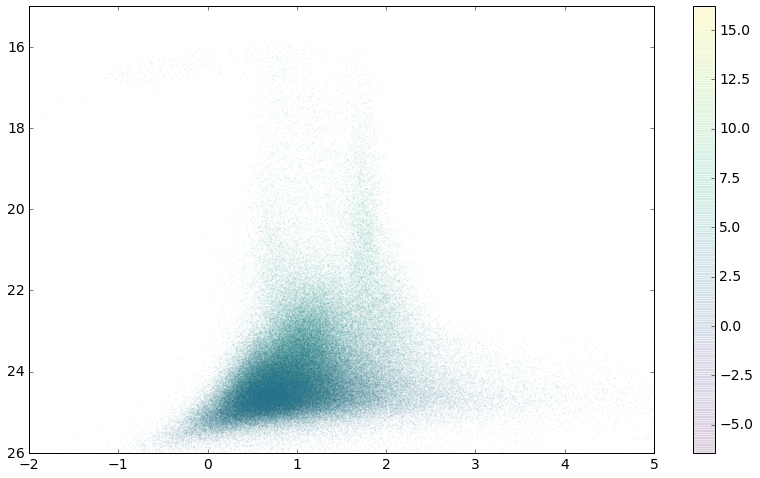

In [55]:
apdiff = subselect_aperture(apmagres - apmag, 'r')
apcolor = subselect_aperture(apmag, 'g') - subselect(apmag, 'r')
apmagx = subselect_aperture(apmag, 'r')

good = ~np.isnan(apdiff)&~np.isnan(apcolor)&~np.isnan(apmagx)

plt.scatter(apcolor[good], apmagx[good], c=apdiff[good], cmap='viridis', alpha=.1, lw=0, s=1)
plt.colorbar()
plt.xlim(-2,5)
plt.ylim(26,15)

# Inspect objects with failed residuals

In [105]:
for band in 'ugrizy':
    reses = subselect_aperture(apmagres, band, None)
    print('Band', band)
    for ap, res in zip(DECALS_AP_SIZES, reses.T):
        print('Aperture', ap,'has', 100*np.sum(np.isfinite(res))/len(res),'% good')

Band u
Aperture 0.5 arcsec has 0.0 % good
Aperture 0.75 arcsec has 0.0 % good
Aperture 1.0 arcsec has 0.0 % good
Aperture 1.5 arcsec has 0.0 % good
Aperture 2.0 arcsec has 0.0 % good
Aperture 3.5 arcsec has 0.0 % good
Aperture 5.0 arcsec has 0.0 % good
Aperture 7.0 arcsec has 0.0 % good
Band g
Aperture 0.5 arcsec has 69.4069194652 % good
Aperture 0.75 arcsec has 78.1477336963 % good
Aperture 1.0 arcsec has 80.8846025172 % good
Aperture 1.5 arcsec has 62.2562670881 % good
Aperture 2.0 arcsec has 39.6218404993 % good
Aperture 3.5 arcsec has 13.3274113725 % good
Aperture 5.0 arcsec has 6.7775688428 % good
Aperture 7.0 arcsec has 4.14844894616 % good
Band r
Aperture 0.5 arcsec has 53.488919396 % good
Aperture 0.75 arcsec has 63.3932835735 % good
Aperture 1.0 arcsec has 63.5275659587 % good
Aperture 1.5 arcsec has 50.9597037481 % good
Aperture 2.0 arcsec has 38.2667881822 % good
Aperture 3.5 arcsec has 17.9269291557 % good
Aperture 5.0 arcsec has 10.3159789117 % good
Aperture 7.0 arcsec has

???? Why are so many of the residuals NaN/infs ???

In [101]:
rs = subselect_aperture(apmagres, 'r')
catnotfin = dcatall[~np.isfinite(rs)]
catnotfin['apmagres_allaps'] = subselect_aperture(apmagres, 'r', None)[~np.isfinite(rs)]

make_cutout_comparison_table(catnotfin[np.random.permutation(len(catnotfin))[:10]], 
                             inclres=True, inclmod=True, inclsdss=False, doprint=False,
                             add_annotation=['apmagres_allaps'])

obj,DECALS,DECALS models,DECALS residuals
333227_4315ra=354.97732686dec=0.321862364127decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]apmagres_allaps=[ 27.88560486 nan nan nan nan nan nan nan],,,
338982_3026ra=353.638256713dec=1.27844948276decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]apmagres_allaps=[ 28.25912857 nan nan nan nan nan nan nan],,,
330342_134ra=353.670471835dec=-0.377341360982decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]apmagres_allaps=[ 28.12233925 28.09502411 nan nan nan nan nan nan],,,
327465_791ra=354.458357358dec=-0.853406960291decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]apmagres_allaps=[ 27.59952545 29.10383797 nan 29.67373657 nan nan nan nan],,,
328904_2172ra=354.116062887dec=-0.552547330827decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]apmagres_allaps=[ nan nan nan nan nan nan nan nan],,,
331784_820ra=354.169835443dec=-0.0995525356704decam_anymask=[0 1 0 0 0 0]decam_allmask=[0 0 0 0 0 0]apmagres_allaps=[ 26.87719536 27.11381912 nan nan nan nan nan nan],,,
328901_462ra=353.291802178dec=-0.611641266911decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]apmagres_allaps=[ 27.97387123 30.68734932 nan nan 26.85075188 25.36913109 23.68585968 24.52176666],,,
337543_5791ra=353.868450082dec=1.09954191696decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]apmagres_allaps=[ nan nan nan nan nan nan nan nan],,,
333225_6507ra=354.34506981dec=0.360174741709decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]apmagres_allaps=[ 27.55085754 26.96842766 nan nan nan nan nan nan],,,
328901_5075ra=353.27439035dec=-0.430997346198decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]apmagres_allaps=[ nan 29.83880424 nan nan nan nan nan nan],,,


# Inspect objects with high residuals vs. flux

Note that this includes only those with r<22 to ensure there's not a flux effect

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in subtract
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in less


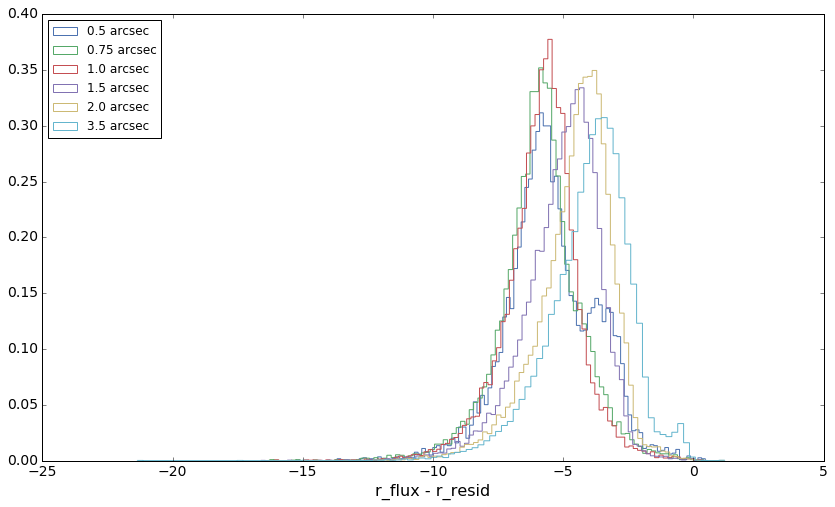

In [146]:
for ap in DECALS_AP_SIZES[:-2]:
    rs = subselect_aperture(apmag, 'r', ap)
    rres = subselect_aperture(apmagres, 'r', ap)

    dmag = rs - rres
    plt.hist(dmag[np.isfinite(dmag)&(rs<22*u.mag)], bins=100, histtype='step', label=str(ap), normed=True)
    
plt.legend(loc=0)
plt.xlabel('r_flux - r_resid')

In [156]:
ap = 1.0*u.arcsec

rs = subselect_aperture(apmag, 'r', ap)
rres = subselect_aperture(apmagres, 'r', ap)
dmag = rs - rres

perc = 95
p = np.percentile(dmag[np.isfinite(dmag)&(rs<22*u.mag)], perc)
print('nobjs in', perc,'percentile:', np.sum(dmag.value>p), 'cutoff is', p)

msk = np.isfinite(dmag)&(dmag.value>p)&(rs<22*u.mag)
dcatbadres = dcatall[msk]
dcatbadres['dmag'] = dmag[msk]
dcatbadres['r'] = rs[msk]

make_cutout_comparison_table(dcatbadres[:10], 
                             inclres=True, inclmod=True, inclsdss=False, doprint=False,
                             add_annotation=['dmag', 'r'])

nobjs in 95 percentile: 171762 cutoff is -3.6490696907


/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in subtract
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in less


obj,DECALS,DECALS models,DECALS residuals
327463_333ra=353.806181204dec=-0.867842838291r=21.0201034546decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-2.8453578949r=21.0201034546,,,
327463_691ra=353.838570951dec=-0.854908081239r=21.2911548615decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-3.33714675903r=21.2911548615,,,
327463_946ra=353.970447627dec=-0.848001103365r=21.9249153137decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-3.3512840271r=21.9249153137,,,
327463_1318ra=353.934400217dec=-0.835109864606r=21.29845047decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-3.13621902466r=21.29845047,,,
327463_2165ra=353.984296108dec=-0.799618561569r=19.8145370483decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-2.5799369812r=19.8145370483,,,
327463_2191ra=353.919553199dec=-0.801457587582r=21.5625934601decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-3.57859992981r=21.5625934601,,,
327463_2779ra=353.889962208dec=-0.77453736284r=20.9005184174decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-2.96533966064r=20.9005184174,,,
327463_2908ra=353.779929784dec=-0.769737173087r=16.4941921234decam_anymask=[0 0 3 0 2 0]decam_allmask=[0 0 0 0 0 0]dmag=-1.66430854797r=16.4941921234,,,
327463_3207ra=353.761256263dec=-0.761058869207r=20.6356163025decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-1.62988090515r=20.6356163025,,,
327463_3666ra=353.884375584dec=-0.740239136879r=21.62383461decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-2.8863697052r=21.62383461,,,


# X-matching to SDSS 

In [177]:
#cut out the non-overlap region
dsc = SkyCoord(dcatall['ra'], dcatall['dec'], unit=u.deg)
dcutall = dcatall[dsc.separation(anak.coords) < 1*u.deg]

In [178]:
dsc = SkyCoord(dcutall['ra'], dcutall['dec'], unit=u.deg)
ssc = SkyCoord(sdss_catalog['ra'], sdss_catalog['dec'], unit=u.deg)
threshold = 1*u.arcsec

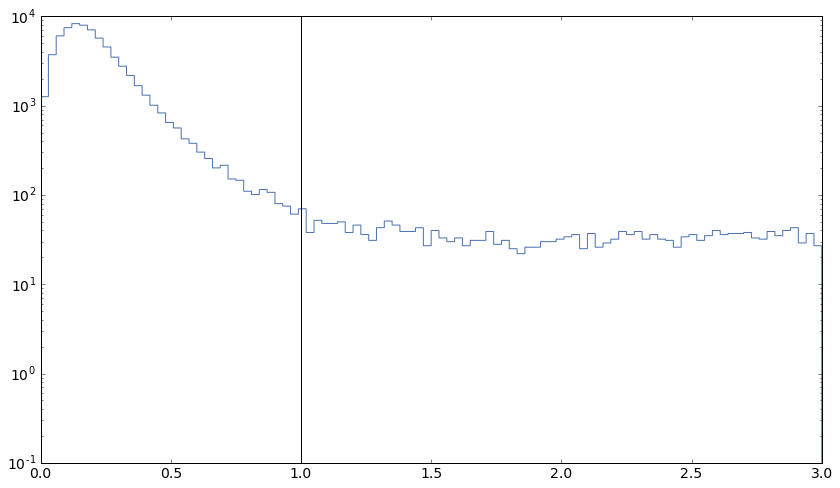

In [179]:
idx, d2d, _ = ssc.match_to_catalog_sky(dsc)
plt.hist(d2d.arcsec, bins=100, range=(0, 3),histtype='step', log=True)
plt.axvline(threshold.to(u.arcsec).value, c='k')
None

In [180]:
dmatchmsk = idx[d2d<threshold]
dmatch = dcutall[dmatchmsk]

smatch = sdss_catalog[d2d<threshold]

In [181]:
idx, d2d, _ = dsc.match_to_catalog_sky(ssc)
dnomatchmsk = d2d>threshold
dnomatch = dcutall[dnomatchmsk]

/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in subtract


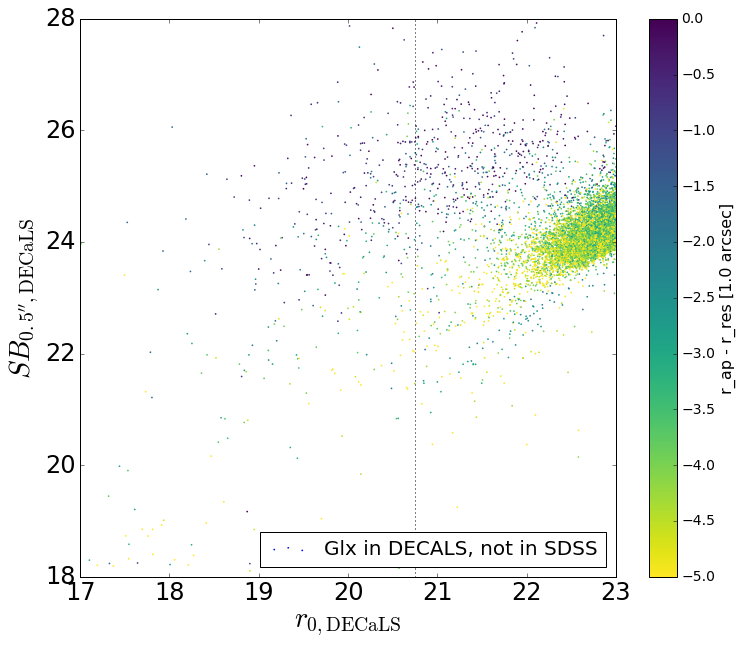

In [223]:
plt.figure(figsize=(12, 10))

xnm = 'r'
ynm = 'sb_r_0.5'

ap = 1*u.arcsec

apmag, apmagerr = fluxivar_to_mag_magerr(dnomatch['decam_apflux'], dnomatch['decam_apflux_ivar'])
apmagres, _ = fluxivar_to_mag_magerr(dnomatch['decam_apflux_resid'], dnomatch['decam_apflux_ivar'])
rs = subselect_aperture(apmag, xnm, ap)
rres = subselect_aperture(apmagres, xnm, ap)
dmag = rs - rres




dnstar = dnomatch['type']=='PSF '
dnoext = -2.5*np.log10(dnomatch['decam_mw_transmission'][:, 2])
r0 = (dnomatch[xnm] - dnoext)
sb = dnomatch[ynm] - dnoext
plt.scatter(r0[~dnstar], sb[~dnstar], 
            c=dmag[~dnstar], lw=0, alpha=1, s=3, label='Glx in DECALS, not in SDSS', vmax=0, vmin=-5,
            cmap='viridis_r')
plt.colorbar().set_label('r_ap - r_res [{}]'.format(ap))

plt.axvline(20.75, color='k', ls=':')

plt.xlim(17, 23)
plt.ylim(18, 28)

plt.xlabel(r'$r_{0, {\rm DECaLS}}$', fontsize=28)
plt.ylabel(r'$SB_{0.5^{\prime \prime}, {\rm DECaLS}}$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.legend(loc='lower right', fontsize=20)

now *inspect* those that are in the upper-left of that plot

In [216]:
msk = (r0[~dnstar]<20.75)&(sb[~dnstar]>24)
cat = dnomatch[~dnstar][msk]
cat['dmag'] = dmag[~dnstar][msk]


/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


In [230]:
p = np.percentile(cat['dmag'][np.isfinite(cat['dmag'])], 10)

catlower = cat[cat['dmag']<p]
print(len(catlower))
make_cutout_comparison_table(catlower[np.random.permutation(len(catupper))[:10]], 
                             inclres=True, inclmod=True, inclsdss=False, doprint=False,
                             add_annotation=['dmag', 'r'])

23


/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


obj,DECALS,DECALS models,DECALS residuals
330344_11ra=354.172535107dec=-0.381236296697r=13.5347957611sb_r_0.5=infdecam_anymask=[ 0 64 67 0 66 0]decam_allmask=[0 0 0 0 0 0]dmag=-infr=13.5347957611,,,
330344_2707ra=354.234954635dec=-0.279673254343r=20.2862873077sb_r_0.5=24.0953636169decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-3.08874320984r=20.2862873077,,,
337544_4059ra=354.051817949dec=1.02560106479r=20.5249004364sb_r_0.5=24.9979362488decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-3.39550018311r=20.5249004364,,,
331784_3784ra=354.048195606dec=0.0181465340088r=20.3882141113sb_r_0.5=25.1399726868decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-4.59214019775r=20.3882141113,,,
334666_3661ra=354.639361466dec=0.510723073664r=20.0610847473sb_r_0.5=24.0979118347decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-3.16948699951r=20.0610847473,,,
331783_5641ra=353.789095491dec=0.0960012819639r=20.7215423584sb_r_0.5=24.2212142944decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-3.78756713867r=20.7215423584,,,
337543_1011ra=353.853768127dec=0.908521771402r=20.0452613831sb_r_0.5=24.3184623718decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-6.39757156372r=20.0452613831,,,
327465_5904ra=354.265223754dec=-0.660394230375r=20.6401500702sb_r_0.5=24.2276535034decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-5.11649513245r=20.6401500702,,,
334665_2419ra=354.409682685dec=0.476746466819r=19.7444648743sb_r_0.5=24.1980171204decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-3.21071815491r=19.7444648743,,,
338983_1502ra=353.901234369dec=1.1915579927r=20.6384811401sb_r_0.5=24.2718410492decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-3.8491153717r=20.6384811401,,,


In [229]:
p = np.percentile(cat['dmag'][np.isfinite(cat['dmag'])], 90)

catupper = cat[cat['dmag']>p]
print(len(catupper))
make_cutout_comparison_table(catupper[np.random.permutation(len(catupper))[:10]], 
                             inclres=True, inclmod=True, inclsdss=False, doprint=False,
                             add_annotation=['dmag', 'r'])

22


/Users/erik/miniconda3/envs/saga/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


obj,DECALS,DECALS models,DECALS residuals
333221_28ra=353.473066743dec=0.124471845579r=20.664937973sb_r_0.5=25.4636592865decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-0.0950031280518r=20.664937973,,,
338984_2407ra=354.240040817dec=1.22365483566r=20.1240921021sb_r_0.5=24.9921379089decam_anymask=[0 0 1 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-0.124256134033r=20.1240921021,,,
330341_1903ra=353.333370644dec=-0.303453892819r=20.5769939423sb_r_0.5=27.9054603577decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-0.121084213257r=20.5769939423,,,
333223_5169ra=353.962108239dec=0.333925799191r=20.7443904877sb_r_0.5=24.1393260956decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-0.0622119903564r=20.7443904877,,,
330347_2401ra=354.780686123dec=-0.280989605527r=20.3637123108sb_r_0.5=24.7463493347decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-0.0565185546875r=20.3637123108,,,
331780_6320ra=353.256240386dec=0.128289642121r=17.1680393219sb_r_0.5=infdecam_anymask=[ 0 1 66 0 2 0]decam_allmask=[0 0 0 0 0 0]dmag=-0.15439414978r=17.1680393219,,,
334663_2808ra=353.882764988dec=0.483849258436r=19.9570236206sb_r_0.5=25.9705181122decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-0.119953155518r=19.9570236206,,,
331787_2374ra=354.844445601dec=-0.02746488785r=20.3349895477sb_r_0.5=26.7209377289decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-0.0651321411133r=20.3349895477,,,
333224_141ra=353.994248716dec=0.125333757659r=20.3014984131sb_r_0.5=25.6945781708decam_anymask=[0 0 0 0 0 0]decam_allmask=[0 0 0 0 0 0]dmag=-0.180147171021r=20.3014984131,,,
331782_664ra=353.494063228dec=-0.102765028355r=19.7340869904sb_r_0.5=24.3124847412decam_anymask=[0 0 0 0 1 0]decam_allmask=[0 0 0 0 0 0]dmag=-0.187227249146r=19.7340869904,,,
